# Proyecto


En este proyecto vamos a hacer machine learning aplicado al ámbito medico ,específicamente diagnostico medico.
Vamos a crear una aplicación que ayuda a diagnosticar si un tumor de seno es cancerígeno (maligno) o no (benigno)   .
Para lograr esto vamos a utilizar un set de datos recopilado por diversos médicos , el cual contiene características de tumores de seno y el diagnostico final . Este es un problema de clasificación binaria ya que solo tenemos dos clases(maligno o benigno), se va a implementar regresión logística para obtener la probabilidad de que el tumor sea maligno.

<img src="images/ai_cancer.png" width="300">

Según lo visto en la clase en este proyecto el estudiante hará  todo el proceso de entrenamiento, evaluación y selección del modelo de machine learning(pasos 1 al 5 del diagrama de flujo de ejemplo) ,luego de seleccionar el mejor va a exportar el modelo (como fue explicado en la clase deployment/despliegue de modelos y va a entregarlo al profesor) ya que  este será utilizado dentro de una aplicación móvil (desarrollada por el profesor, paso 6 del diagrama )


<img src="images/diagrama.png" width="700">

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import datetime
import helper
import math

## Registro de Experimentos
En machine learning y ciencia de datos es importante tener un registro de los resultados de cada experimento realizado, así como la configuración del sistema(tal como learning-rate, numero de iteraciones, cantidad de observaciones y features, etc) que llevo a determinados resultados, esto porque el proceso puede llegar a ser muy iterativo y nos es útil saber en todo momento que caso tuvo los mejores resultados. Por esta razón en este proyecto utilizamos una bitácora o log-book científico en el cual tenemos la configuración de nuestros modelos y los resultados(métricas de evaluación) de cada uno.

In [4]:
log_book = helper.load_log_book()

Una vez la bitacora contenga informacion ,puedes consultarla en cualquier celda usando:

helper.print_log_book(log_book)

Para guardar la bitacora (una vez has capturado el resultado de los experimentos que realizaremos) usaremos el siguiente codigo(hay mas detalles mas adelante)

helper.guardar_log_book(log_book)

## Carnet estudiante

 La aplicación móvil resultante tendrá un modelo por estudiante, por lo cual es importante identificar a que estudiante pertenece cada modelo, por esta razón  en el proceso de exportar el modelo el archivo resultante tendrá en su nombre el carnet del estudiante. 
 
 En una variable deben ingresar su numero de carnet, para que al exportar el modelo el archivo se llame `carnet+"model.csv"`. Por ejemplo 200818835model.csv

In [5]:
carnet = "20150066"

## Breast Cancer Data Set

El dataset que usaremos contiene varias características(features) , más adelante encontraras instrucciones de cómo trabajar con estas. En el siguiente enlace puedes acceder a mayor información y detalles del dataset.

[Link al set de datos](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer)

#### Data Set Information:

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. A few of the images can be found at [Web Link] 

Separating plane described above was obtained using Multisurface Method-Tree (MSM-T) [K. P. Bennett, "Decision Tree Construction Via Linear Programming." Proceedings of the 4th Midwest Artificial Intelligence and Cognitive Science Society, pp. 97-101, 1992], a classification method which uses linear programming to construct a decision tree. Relevant features were selected using an exhaustive search in the space of 1-4 features and 1-3 separating planes. 

The actual linear program used to obtain the separating plane in the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34]. 

In [6]:
data = load_breast_cancer()

Este es un problema de clasificacion binario por que que existen solo dos posibles valores(predecimos tumores cancerigenos de seno)

In [7]:
data.target_names

array(['malignant', 'benign'], dtype='<U9')

El data set tiene varios features, por lo  que debemos experimentar con diferentes features y analizar los resultados, en esta celda vamos a imprimir los nombres de las features que poseemos.

En este [link](https://goo.gl/U2Uwz2) podemos encontrar mas información sobre las features.

Nota: Aunque a lo largo del proyecto, usaremos distintas features para entrenar diversos modelos y entender cómo funciona el proceso de ML y el impacto del uso de diversas features, en el resultado final (el modelo que será exportado e integrado a la aplicación móvil) solo usaremos las primeras 5 features.



In [8]:
data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

muestra de las primeras 5 labels/etiquetas

In [9]:
data.target[0:5]

array([0, 0, 0, 0, 0])

las features para estos 5 casos de ejemplo

In [10]:
data.data[0:5,]

array([[1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
        3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
        8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
        3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
        1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, 1.326e+03, 8.474e-02, 7.864e-02,
        8.690e-02, 7.017e-02, 1.812e-01, 5.667e-02, 5.435e-01, 7.339e-01,
        3.398e+00, 7.408e+01, 5.225e-03, 1.308e-02, 1.860e-02, 1.340e-02,
        1.389e-02, 3.532e-03, 2.499e+01, 2.341e+01, 1.588e+02, 1.956e+03,
        1.238e-01, 1.866e-01, 2.416e-01, 1.860e-01, 2.750e-01, 8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, 1.203e+03, 1.096e-01, 1.599e-01,
        1.974e-01, 1.279e-01, 2.069e-01, 5.999e-02, 7.456e-01, 7.869e-01,
        4.585e+00, 9.403e+01, 6.150e-03, 4.006e-02, 3.832e-02, 2.058e-02,
        2.250e-02, 4.571e-03, 2.357e

# Implementación de Regresión Logística 

## Hipótesis
Función Sigmoid:

$sig(t) = {\frac {1} {1 + e^{-t}}}$

Combinamos la función sigmoid/lógistica con la  hipótesis conocida (aprendida en regresión lineal) y tenemos la nueva hipótesis para clasificación con regresión lógistica:

$z = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + \ldots + \theta_{n}x_{n}$

$g(z) = {\frac {1} {1 + e^{-z}}}$

** Hipótesis para clasificación con regresión logística: **

$h_{\theta}(x) = {\frac {1} {1 + e^{-(\theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + \ldots + \theta_{n}x_{n})}}}$

In [11]:
## Sigmoid 

def sigmoid(z):
    ### INICIO: TU CODIGO AQUI:  (~1 linea)###
    s = 1/(1+np.exp(-z))
    ### FIN ##
    
    return s

In [12]:
### Validando nuestra funcion sigmoid
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))

sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


#### Resultados esperados

**sigmoid(0)** = 0.5

**sigmoid(9.2)** = 0.999898970806


Implementado la hipótesis/modelo para clasificación con regresión logística

** Hipótesis para clasificación con regresión logística: **

$h_{\theta}(x) = {\frac {1} {1 + e^{-(\theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + \ldots + \theta_{n}x_{n})}}}$

In [13]:
def get_hipotesis(features, theta_values):
    ## Calculo de la hipotesis de froma vectorizada,producto punto entre el vector de features y el vector de parametros theta ##
    z = features.dot(theta_values)
    
    ### INICIO: TU CODIGO AQUI:  (~1 linea)###
    h = 1/(1+np.exp(-z))
    ### FIN ##
    
    return h

# Métricas de evaluación

Tal como lo vimos en la clase 22: evaluación , utilizamos diversas métricas para evaluar y reportar la exactitud y rendimiento de nuestros modelos de machine learning. En clasificación usamos el costo: cross-entropy para entrenar, pero evaluamos y reportamos diversas métricas mas .

## Costo

El proceso de gradient descent busca minimizar la siguiente función de costo en función de los parámetros theta, y así encontrar los parámetros que producen una hipótesis optima. 

El costo mide que tan buena o mala es una hipótesis por lo cual esperamos que este disminuya durante el entrenamiento.

$J(\Theta) = - {\frac {1}{m}}\sum _{i=1}^{m} y \log(h(x)) + (1-y)\log(1-h(x))$

Utiliza la funcion log de numpy, Ejemplo:
`np.log(y)`

In [14]:
def costo(X, theta_vector, y):
    m = len(y)
    
    ### INICIO: TU CODIGO AQUI:  (~2 lineas)###
    y_hat = get_hipotesis(X,theta_vector)
    
    costo = np.sum(y*(np.log(y_hat+(1-y)*np.log(1-y_hat))))/m

    ### FIN ##
    
    return costo

## Accuracy Score

Implementa la funcion de accuracy utlizando sklearn(puedes utilizar como referencia la clase 22: evaluación )

In [15]:
def accuracy(X, theta_vector, y):

    hipotesis = get_hipotesis(X, theta_vector)
    
    # Convertimos el resultado probabilistico a deterministico (0 1)
    y_pred = [1 if (y >= 0.5) else 0 for y in hipotesis]
    
    ### INICIO: TU CODIGO AQUI:  (~1 linea)###
    acc_score = accuracy_score(y, y_pred)
    ### FIN ##
    
    return acc_score

## F1 Score

Implementa la funcion de f1_score utlizando sklearn(puedes utilizar como referencia la clase 22: evaluación )

In [16]:
def f1(X, theta_vector, y):

    hipotesis = get_hipotesis(X, theta_vector)

    # Convertimos el resultado probabilistico a deterministico (0 1)    
    y_pred = [1 if (y >= 0.5) else 0 for y in hipotesis ]
    
    ## INICIO: TU CODIGO AQUI:  (~1 linea)###
    f1 = f1_score(y, y_pred)
       ### FIN ##
    
    return f1

## Precision Score

Implementa la funcion de precision_score utlizando sklearn(puedes utilizar como referencia la clase 22: evaluación )

In [17]:
def precision(X, theta_vector, y):

    hipotesis = get_hipotesis(X, theta_vector)

    # Convertimos el resultado probabilistico a deterministico (0 1)    
    y_pred = [1 if (y >= 0.5) else 0 for y in hipotesis ]
    
    ## INICIO: TU CODIGO AQUI:  (~1 linea)###
    precision = precision_score(y, y_pred)
    ### FIN ##
    
    return precision

## Recall Score

Implementa la funcion de recall_score utlizando sklearn(puedes utilizar como referencia la clase 22: evaluación )

In [18]:
def recall(X, theta_vector, y):

    hipotesis = get_hipotesis(X, theta_vector)

    # Convertimos el resultado probabilistico a deterministico (0 1)    
    y_pred = [1 if (y >= 0.5) else 0 for y in hipotesis ]
    
    ## INICIO: TU CODIGO AQUI:  (~1 linea)###
    reacall = recall_score(y, y_pred)
    ### FIN ##
    
    return recall

# Pre-procesamiento

En Machine learning, la fase de pre-procesamiento(incluyendo feature engineering) de datos puede llegar a abarcar el 70% o más del tiempo de un proyecto , pero este es un tema que se profundiza en otros cursos del área de ciencia de datos por lo cual en este proyecto solo vamos a realizar como pre-procesamiento una normalización de features.

### Estandarización o Z-score Normalizacion 

El objetivo de la normalización es ayudar a gradient descent a encontrar el mínimo del costo mas rápido y fácilmente , esto se logra a través de convertir las features de manera que tengan media = 0 y desviación estándar de 1 , similar a una distribución de probabilidad normal(gaussiana).

Lo calculamos utilizando:

$z = {\frac {x - \mu} {\sigma}}$

Donde $\mu$ es la media y $\sigma$ es la desviacion estandard

##### Comentario opcional:
el Z-score en el nombre concuerda con el uso de "z-scores" en estadística cuando se hace estadística inferencial(prueba de hipótesis e intervalos de confianza)

Implementa la funcion de normalizacion sin utlizar sklearn solo puedes utilizar numpy.

Para utilizar la columna de features, utilizamos `features[:,i]`

In [19]:
def normalizar(features):
    std = 1
    media = 0
    
    # Utilizamos el ciclo, para normalizar cada feature(una iteracion por feature)
    for i in list(range(0, features.shape[1])):
        ### INICIO: TU CODIGO AQUI:  (~3 lineas)###
        std = np.std(features)
        media = np.mean(features)
        features[:,i] = (features[:,i] - media) / std;
        ### FIN ##
    return features

## Prediccion

Una vez entrenado, el modelo de ML se utiliza para realizar predicciones ,en este proyecto realizaremos predicciones en un train y un test set(no usaremos cross-validation set)  .Una  vez exportado y entregado el modelo al profesor, el modelo realizara predicciones dentro de una aplicación móvil . 

La siguiente función la vamos a utilizar para realizar predicciones a lo largo del proyecto(y así poder medir contra los datos reales para realizar evaluación), no hay que cambiar nada del código, solo ejecuta la celda.

In [20]:
def prediccion(x, theta_vector, normalizar_valores):
    numero_features = x.shape[1] + 1
    
    if (normalizar_valores):
        x = normalizar(x)
    
    x_features = np.ones((x.shape[0], numero_features))
    x_features[:,:-1] = x

    
    y_hat = get_hipotesis(x_features, theta_vector)
    
    return np.array([1 if (y >= 0.5) else 0 for y in y_hat])

## Gradient Descent

Gradient descent es el algoritmo o método de optimización matemática que nos permite realizar el “entrenamiento” de nuestro modelos, ya que minimiza el costo y nos devuelve los parámetros del modelo óptimos.

En la siguiente celda, debes implementar gradient descent tal como visto en clase y practicado en las tareas .

Lo definimos e implementamos dentro de una función de Python para que podamos ejecutarlo(“llamarlo”) múltiples veces con distintos parámetros, sin tener que volver a programarlo cada vez , esto nos será útil para experimentar y entrenar varios modelos.

Repetir{

$\theta_{j} := \theta _{j} - \alpha {\frac {1}{m}} \sum _{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})x^{(i)}_{j}$

}
        
Simultaneamente para cada $j = 0,\ldots,n $

In [21]:
def gradient_descent(X, y, theta_vector, alpha, iterations, X_test, y_test, nombre_modelo):
    global log_book
    m = len(y)  #numero de ejemplos de entrenamiento

    ## Las siguientes 3 lineas de codigo crean listas vacias para almacenar el costo y accuracy obtenido en cada iteracion
    ## Se espera que el costo disminuya y el accuracy aumente
    cost_vect = []
    accuracy_vect = []
    accuracy_vect_test = []
    
    for iteration in range(iterations):
        '''
        IMPLELEMTA TU CODIGO AQUI, llama a la funcion para calcular la hipotesis,es decir calcular h(x)
        que se implemento mas arriba. Parametros matriz de features X y el vector
        con los valores Theta (~1 linea)
        '''
        hipotesis = get_hipotesis(X, theta_vector)


        theta_vector_temp = [] # vector que guarda los parametros theta temporales
        
        # Utilizamos un ciclo para realizar la actualizacion de gradient descent una vez para cada parametro
        # En cada iteracion "i" guarda el numero de parametro theta, y la varaible "theta" guarda el parametro como tal
        for i, theta in enumerate(theta_vector):
            '''
            IMPLELEMTA TU CODIGO AQUI, adentro de este ciclo vamos a calcular
            elnuevo valor de Theta[i], utilizando la formula de la celda de arriba
            Recuerda que para multiplicar por utilizamos X[:,i]  (~1 linea)
            '''
            nuevo_theta = theta-alpha*(1/(int(m))*np.sum(np.subtract(hipotesis,y)*X[:,i]))

            ### aqui agregamos el nuevo valor the theta[i] a un vector temporal
            theta_vector_temp.append(nuevo_theta)


        ## Actualizamos el vector theta con los nuevos valores
        theta_vector = theta_vector_temp

        # En las sigiuentes lineas calculamos las metricas de evaluacion en cada iteracion(aplicadas al train-set)
        '''
        IMPLEMENTA TU CODIGO AQUI, llama a la funcion de costo (~1 linea)
        '''
        cost = costo(X, theta_vector, y)
        
        '''
        IMPLEMENTA TU CODIGO AQUI, utiliza Accuracy que se definio arriba (~1 linea)
        '''
        y_pred = [1 if (y >= 0.5) else 0 for y in hipotesis]
        acc_score = accuracy_score(y, y_pred, normalize=True)
        
        '''
        IMPLEMENTA TU CODIGO AQUI, utiliza f1 score que se definio arriba (~1 linea)
        '''
        f1_training = f1(X, theta_vector, y)

        '''
        IMPLEMENTA TU CODIGO AQUI, utiliza precision score que se definio arriba (~1 linea)
        '''
        precision_training = precision(X, theta_vector, y) 
        
        '''
        IMPLEMENTA TU CODIGO AQUI, utiliza recall score que se definio arriba (~1 linea)
        '''
        recall_training = recall(X, theta_vector, y)
        
        
        ## En las siguientes lineas calculamos las metricas de evaluacion aplicadas al test-set, este codigo no hay que cambiarlo ####
        y_predict = prediccion(X_test, theta_vector, True)
        acc_test = accuracy_score(y_predict, y_test)
        accuracy_vect_test.append(acc_test)
        f1_score_test = f1_score(y_predict, y_test)
        precision_test = precision_score(y_test, y_predict)
        recall_test = recall_score(y_test, y_predict)
        
        ## Guardando el valor del costo para graficarlo, este codigo no hay que cambiarlo ##
        cost_vect.append(cost)
        accuracy_vect.append(acc_score)
        
        n = 300 ### Ingresa aqui cada cuantas iteraciones quieres que se imprima el valor de las metricas ###
        
        ## Este codigo no hay que modificarlo ##
        if(iteration % n == 0):
            print('#####################')
            print('TRAINING: [Iteracion: ', iteration,' Costo: ', cost, \
                  ' Accuracy:', acc_score,' F1 Score:',f1_training, \
                  'Precision training:', precision_training, 'Recall training:', recall_training,']')
            print('TEST: [Iteracion: ', iteration,'Accuracy:', acc_test, \
                  ' F1 Score:', f1_score_test, 'Precision Test:', precision_test,'Recall Test:', recall_test,']')
        
    ## Log book, este codigo no hay que cambiarlo, sirve para guardar en la bitacora los resultados del experimento ##
    nombre_modelo = nombre_modelo + '_'+datetime.datetime.now().strftime("%d%H%M%f")
    numero_features = X.shape[1] - 1
    experiment = np.array([nombre_modelo, numero_features, m, alpha, iterations, accuracy_vect[-1], \
                           accuracy_vect_test[-1], f1_score_test, precision_test, \
                           recall_test,theta_vector], dtype=object)
    log_book = np.vstack([log_book, experiment])
        
    return theta_vector, cost_vect, accuracy_vect,accuracy_vect_test


## Dividimos la data en training y test set

Tal como visto en la clase 23, nos sirve para evaluar objetivamente el rendimiento de nuestros modelos en datos que nunca ha visto durante su entrenamiento

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, stratify=data.target, random_state=42)

In [23]:
X_train.shape

(426, 30)

# Entrenamiento

## Features a utilizar
A continuación, vamos a entrenar varios modelos, vamos a utilizar las funciones que creamos previamente.
Es importante experimentar con diferentes features,diverso tamaño del training set, y diversos hyper-parametros(learning rate e iteraciones)

En este proyecto como máximo vamos a utilizar 5 features(pero en algunos experimentos usaremos menos) de manera obligatoria, pero de forma opcional se recomienda experimentar con más y diversas combinaciones ,esto para practicar y obtener experiencia con ML. 

También vamos a utilizar diferente número de ejemplos en el set de datos, diferente número de iteraciones y diferente learning rate . Todas estas distintas configuraciones serán almacenadas en el log-book(bitácora) automáticamente .

En este proyecto solo vamos a utilizar las primeras 5 features  en este orden:

`['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness']`

La razón por las que usaremos estas 5 features específicamente(y en este orden) en el modelo final(el que será exportado) es que estas features son las que serán utilizadas en la aplicación móvil en la cual integraremos el modelo(y tendremos en la interfaz de usuario de la aplicación componentes para ingresar valores para estas features),ero como se mencionó se recomienda experimentar y evaluar resultados con distintas features y distinto número  de ellas .

## Descripcion del entrenamiento
El entrenamiento de cada modelo se compone básicamente de tres pasos, sampleo bootstrap, escoger las features y ejecutar el entrenamiento llamando a la función de gradient descent que ya creamos.

En el primer paso vamos a utilizar la función resample para hacer un sampleo del set de datos de entrenamiento, debemos definir el numero de samples que queremos utilizar.

En el segundo paso, en un arreglo vamos a definir el nombre de las features que queremos utilizar para entrenar el modelo.
En el tercer paso ejecutamos la función gradient descent.

Por ultimo vamos a obtener el accuracy del modelo y vamos a imprimir la matriz de confusión, imprimiremos el precisión y el recall del modelo para entender mejor los resultados y tener una mejor idea de que tan bien clasifica nuestro modelo.

## Entrenamiento modelo 1

#### Sampleo bootstrap

In [24]:
X_train_m1, Y_train_m1 = resample(X_train, y_train, n_samples = 460)

### Filtrar Features
Solo seleccionar los features

In [25]:
'''
Ingresa en la lista el nombre de las fatrues que quieres utlizar en este modelo (~1 linea)
'''
features_filtro = ['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness']

In [26]:
X_train_m1 = helper.fitrar_nombre(X_train_m1,data.feature_names,features_filtro)
X_test_features = helper.fitrar_nombre(X_test,data.feature_names,features_filtro)

In [27]:
X_train_m1.shape

(460, 5)

In [28]:
X_test_features.shape

(143, 5)

In [29]:
## Numero de iteracions ##
iterations = 2000  # Define el numero de iteraciones #

## Alpha ##
alpha = 0.01 # Define el valor de alpha #

#### No hay que cambiar el codigo despues de esta linea #####
## Numero de feautres ##
numero_features = X_train_m1.shape[1] + 1

## Creamos un vector donde se almacenan los valores de Theta,
## lo inicializamos con numeros aleatorios
theta_vector = np.random.rand(numero_features)

## Normaliza las features de X_train_features (~1 linea) ##
X_train_m1 = normalizar(X_train_m1)

# Creando la Matriz X de features, 
# utilizamos np.ones para agregar el valor constante '1' que es el bias o feature 0
X_train_features = np.ones((X_train_m1.shape[0], numero_features))
X_train_features[:,:-1] = X_train_m1

In [30]:
modelo_1_theta_values, cost_vect, acc_vect, acc_vect_test = \
gradient_descent(X_train_features, Y_train_m1, theta_vector, alpha, iterations, X_test_features, y_test, 'modelo_1')

C:\Users\Admin VDK\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


#####################
TRAINING: [Iteracion:  0  Costo:  nan  Accuracy: 0.5260869565217391  F1 Score: 0.6894586894586895 Precision training: 0.599009900990099 Recall training: <function recall at 0x000002040C1480D0> ]
TEST: [Iteracion:  0 Accuracy: 0.5314685314685315  F1 Score: 0.6940639269406393 Precision Test: 0.5891472868217055 Recall Test: 0.8444444444444444 ]


C:\Users\Admin VDK\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Admin VDK\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#####################
TRAINING: [Iteracion:  300  Costo:  nan  Accuracy: 0.28695652173913044  F1 Score: 0.0 Precision training: 0.0 Recall training: <function recall at 0x000002040C1480D0> ]
TEST: [Iteracion:  300 Accuracy: 0.3706293706293706  F1 Score: 0.0 Precision Test: 0.0 Recall Test: 0.0 ]


C:\Users\Admin VDK\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#####################
TRAINING: [Iteracion:  600  Costo:  nan  Accuracy: 0.8804347826086957  F1 Score: 0.9139280125195618 Precision training: 0.8563049853372434 Recall training: <function recall at 0x000002040C1480D0> ]
TEST: [Iteracion:  600 Accuracy: 0.8671328671328671  F1 Score: 0.8972972972972973 Precision Test: 0.8736842105263158 Recall Test: 0.9222222222222223 ]
#####################
TRAINING: [Iteracion:  900  Costo:  nan  Accuracy: 0.8717391304347826  F1 Score: 0.9085271317829458 Precision training: 0.8443804034582133 Recall training: <function recall at 0x000002040C1480D0> ]
TEST: [Iteracion:  900 Accuracy: 0.8601398601398601  F1 Score: 0.8969072164948454 Precision Test: 0.8365384615384616 Recall Test: 0.9666666666666667 ]
#####################
TRAINING: [Iteracion:  1200  Costo:  nan  Accuracy: 0.8717391304347826  F1 Score: 0.9085271317829458 Precision training: 0.8443804034582133 Recall training: <function recall at 0x000002040C1480D0> ]
TEST: [Iteracion:  1200 Accuracy: 0.8

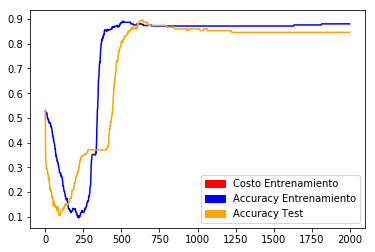

In [31]:
## Funcion para graficar el costo y  accuracy durante cada iteracion ##
helper.training_graph(cost_vect, acc_vect, acc_vect_test)

### Accuracy y Matriz de confusion Training Set

![alt text](https://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png)

In [32]:
y_hat = get_hipotesis(X_train_features, modelo_1_theta_values)
y_predict = np.array([1 if (y > 0.5) else 0 for y in y_hat])

print('Accuracy:', accuracy_score(Y_train_m1,y_predict) * 100 ,'%')
print()
print('Matriz de confusion')
confusion_matrix(Y_train_m1, y_predict )

Accuracy: 88.04347826086956 %

Matriz de confusion


array([[112,  50],
       [  5, 293]], dtype=int64)

#### Accuracy con el Test set

In [33]:
y_predict = prediccion(X_test_features, modelo_1_theta_values, True)

In [34]:
print('Accuracy:',accuracy_score(y_test, y_predict)* 100 ,'%')

Accuracy: 84.61538461538461 %


#### Matriz de confusion Test Set

In [35]:
confusion_matrix(y_test, y_predict)

array([[32, 21],
       [ 1, 89]], dtype=int64)

In [36]:
print('precision: ',precision_score(y_test, y_predict))

print('recall: ', recall_score(y_test, y_predict))

precision:  0.8090909090909091
recall:  0.9888888888888889


## Entrenamiento modelo 2

#### Sampleo bootstrap

In [37]:
'''
Ingresa en la lista el nombre de las fatrues que quieres utlizar en este modelo (~1 linea)
'''
X_train_m2, Y_train_m2 = resample(X_train, y_train, n_samples = 400)

### Filtrar Features
Solo seleccionar los features

In [38]:
features_filtro = ['mean perimeter', 'mean area','mean smoothness']

In [39]:
X_train_m2 = helper.fitrar_nombre(X_train_m2,data.feature_names,features_filtro)
X_test_features = helper.fitrar_nombre(X_test,data.feature_names,features_filtro)

In [40]:
## Numero de iteracions ##
iterations = 1000  # Define el numero de iteraciones #

## Alpha ##
alpha = 0.05 # Define el valor de alpha #

#### No hay que cambiar el codigo despues de esta linea #####
## Numero de feautres ##
numero_features = X_train_m2.shape[1] + 1

## Creamos un vector donde se almacenan los valores de Theta,
## lo inicializamos con numeros aleatorios
theta_vector = np.random.rand(numero_features)

## Normaliza las features de X_train_features (~1 linea) ##
X_train_m2 = normalizar(X_train_m2)

# Creando la Matriz X de features, 
# utilizamos np.ones para agregar el valor constante '1' que es el bias o feature 0
X_train_features = np.ones((X_train_m2.shape[0], numero_features))
X_train_features[:,:-1] = X_train_m2

In [41]:
## Llama a la funcion de gradient descent, recurda definir un nombre diferente para el modelo (~1 linea) ##
modelo_2_theta_values, cost_vect, acc_vect, acc_vect_test = \
gradient_descent(X_train_features, Y_train_m2, theta_vector, alpha, iterations, X_test_features, y_test, 'modelo_2')
### FIN ##

C:\Users\Admin VDK\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


#####################
TRAINING: [Iteracion:  0  Costo:  nan  Accuracy: 0.6225  F1 Score: 0.7673343605546996 Precision training: 0.6225 Recall training: <function recall at 0x000002040C1480D0> ]
TEST: [Iteracion:  0 Accuracy: 0.6293706293706294  F1 Score: 0.7725321888412017 Precision Test: 0.6293706293706294 Recall Test: 1.0 ]
#####################
TRAINING: [Iteracion:  300  Costo:  nan  Accuracy: 0.8875  F1 Score: 0.9149338374291115 Precision training: 0.8642857142857143 Recall training: <function recall at 0x000002040C1480D0> ]
TEST: [Iteracion:  300 Accuracy: 0.8601398601398601  F1 Score: 0.8979591836734695 Precision Test: 0.8301886792452831 Recall Test: 0.9777777777777777 ]
#####################
TRAINING: [Iteracion:  600  Costo:  nan  Accuracy: 0.89  F1 Score: 0.9163498098859316 Precision training: 0.8700361010830325 Recall training: <function recall at 0x000002040C1480D0> ]
TEST: [Iteracion:  600 Accuracy: 0.8531468531468531  F1 Score: 0.8944723618090452 Precision Test: 0.8165137

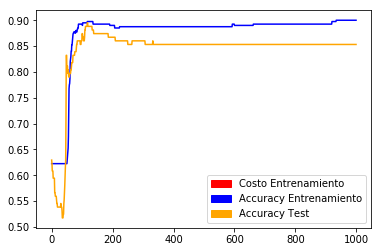

In [42]:
## Funcion para graficar el costo y  accuracy durante cada iteracion ##
helper.training_graph(cost_vect, acc_vect, acc_vect_test)

#### Accuracy con el Test set [Modelo 2]

In [43]:
y_predict = prediccion(X_test_features, modelo_2_theta_values, True)

In [44]:
print('Accuracy:',accuracy_score(y_test, y_predict)* 100 ,'%')

Accuracy: 85.3146853146853 %


#### Matriz de confusion Test Set [Modelo 2]

In [45]:
confusion_matrix(y_test, y_predict)

array([[33, 20],
       [ 1, 89]], dtype=int64)

In [46]:
print('precision: ',precision_score(y_test, y_predict))

print('recall: ', recall_score(y_test, y_predict))

precision:  0.8165137614678899
recall:  0.9888888888888889


## Entrenamiento modelo 3

#### Sampleo bootstrap

In [47]:
X_train_m3, Y_train_m3 = resample(X_train, y_train, n_samples = 460)

### Filtrar Features
Solo seleccionar los features

In [48]:
'''
Ingresa en la lista el nombre de las fatrues que quieres utlizar en este modelo (~1 linea)
'''
features_filtro = ['mean radius', 'mean texture', 'mean perimeter', 'mean area']

In [49]:
X_train_m3 = helper.fitrar_nombre(X_train_m3,data.feature_names,features_filtro)
X_test_features = helper.fitrar_nombre(X_test,data.feature_names,features_filtro)

In [50]:
## Numero de iteracions ##
iterations = 1500  # Define el numero de iteraciones #

## Alpha ##
alpha = 0.02 # Define el valor de alpha #

#### No hay que cambiar el codigo despues de esta linea #####
## Numero de feautres ##
numero_features = X_train_m3.shape[1] + 1

## Creamos un vector donde se almacenan los valores de Theta,
## lo inicializamos con numeros aleatorios
theta_vector = np.random.rand(numero_features)

## Normaliza las features de X_train_features (~1 linea) ##
X_train_m3 = normalizar(X_train_m3)

# Creando la Matriz X de features, 
# utilizamos np.ones para agregar el valor constante '1' que es el bias o feature 0
X_train_features = np.ones((X_train_m3.shape[0], numero_features))
X_train_features[:,:-1] = X_train_m3

In [51]:
## Llama a la funcion de gradient descent, recurda definir un nombre diferente para el modelo (~1 linea) ##
modelo_3_theta_values, cost_vect, acc_vect, acc_vect_test = \
gradient_descent(X_train_features, Y_train_m3, theta_vector, alpha, iterations, X_test_features, y_test, 'modelo_3')
### FIN 

C:\Users\Admin VDK\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


#####################
TRAINING: [Iteracion:  0  Costo:  nan  Accuracy: 0.6391304347826087  F1 Score: 0.779840848806366 Precision training: 0.6391304347826087 Recall training: <function recall at 0x000002040C1480D0> ]
TEST: [Iteracion:  0 Accuracy: 0.6293706293706294  F1 Score: 0.7725321888412017 Precision Test: 0.6293706293706294 Recall Test: 1.0 ]
#####################
TRAINING: [Iteracion:  300  Costo:  nan  Accuracy: 0.8869565217391304  F1 Score: 0.917981072555205 Precision training: 0.8558823529411764 Recall training: <function recall at 0x000002040C1480D0> ]
TEST: [Iteracion:  300 Accuracy: 0.8601398601398601  F1 Score: 0.8979591836734695 Precision Test: 0.8301886792452831 Recall Test: 0.9777777777777777 ]
#####################
TRAINING: [Iteracion:  600  Costo:  nan  Accuracy: 0.8891304347826087  F1 Score: 0.9194312796208531 Precision training: 0.8584070796460177 Recall training: <function recall at 0x000002040C1480D0> ]
TEST: [Iteracion:  600 Accuracy: 0.8531468531468531  F1 Sco

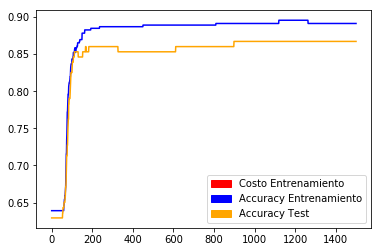

In [52]:
## Funcion para graficar el costo y  accuracy durante cada iteracion
helper.training_graph(cost_vect, acc_vect, acc_vect_test)

#### Accuracy con el Test set [Modelo 3]

In [53]:
y_predict = prediccion(X_test_features, modelo_3_theta_values, True)

In [54]:
print('Accuracy:',accuracy_score(y_test, y_predict)* 100 ,'%')

Accuracy: 86.7132867132867 %


#### Matriz de confusion Test Set [Modelo 3]

In [55]:
confusion_matrix(y_test, y_predict)

array([[37, 16],
       [ 3, 87]], dtype=int64)

In [56]:
print('precision: ',precision_score(y_test, y_predict))

print('recall: ', recall_score(y_test, y_predict))

precision:  0.8446601941747572
recall:  0.9666666666666667


## Entrenamiento modelo 4

#### Sampleo bootstrap

In [57]:
X_train_m4, Y_train_m4 = resample(X_train, y_train, n_samples = 460)

### Filtrar Features
Solo seleccionar los features

In [58]:
'''
Ingresa en la lista el nombre de las fatrues que quieres utlizar en este modelo (~1 linea)
'''
features_filtro = ['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness']

In [59]:
X_train_m4 = helper.fitrar_nombre(X_train_m4,data.feature_names,features_filtro)
X_test_features = helper.fitrar_nombre(X_test,data.feature_names,features_filtro)

In [60]:
## Numero de iteracions ##
iterations = 2000 # Define el numero de iteraciones #

## Alpha ##
alpha = 0.03 # Define el valor de alpha #

#### No hay que cambiar el codigo despues de esta linea #####
## Numero de feautres ##
numero_features = X_train_m4.shape[1] + 1

## Creamos un vector donde se almacenan los valores de Theta,
## lo inicializamos con numeros aleatorios
theta_vector = np.random.rand(numero_features)

## Normaliza las features de X_train_features (~1 linea) ##
X_train_m4 = normalizar(X_train_m4)

# Creando la Matriz X de features
X_train_features = np.ones((X_train_m4.shape[0], numero_features))
X_train_features[:,:-1] = X_train_m4

In [61]:
## Llama a la funcion de gradient descent, recurda definir un nombre diferente para el modelo (~1 linea) ##
modelo_4_theta_values, cost_vect, acc_vect, acc_vect_test = \
gradient_descent(X_train_features, Y_train_m4, theta_vector, alpha, iterations, X_test_features, y_test, 'modelo_4')

C:\Users\Admin VDK\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


#####################
TRAINING: [Iteracion:  0  Costo:  nan  Accuracy: 0.14130434782608695  F1 Score: 0.005037783375314862 Precision training: 0.010309278350515464 Recall training: <function recall at 0x000002040C1480D0> ]
TEST: [Iteracion:  0 Accuracy: 0.16083916083916083  F1 Score: 0.0 Precision Test: 0.0 Recall Test: 0.0 ]


C:\Users\Admin VDK\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Admin VDK\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Admin VDK\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#####################
TRAINING: [Iteracion:  300  Costo:  nan  Accuracy: 0.8826086956521739  F1 Score: 0.9153605015673981 Precision training: 0.863905325443787 Recall training: <function recall at 0x000002040C1480D0> ]
TEST: [Iteracion:  300 Accuracy: 0.8671328671328671  F1 Score: 0.9015544041450777 Precision Test: 0.8446601941747572 Recall Test: 0.9666666666666667 ]
#####################
TRAINING: [Iteracion:  600  Costo:  nan  Accuracy: 0.8891304347826087  F1 Score: 0.9196850393700788 Precision training: 0.8716417910447761 Recall training: <function recall at 0x000002040C1480D0> ]
TEST: [Iteracion:  600 Accuracy: 0.8531468531468531  F1 Score: 0.8944723618090452 Precision Test: 0.8165137614678899 Recall Test: 0.9888888888888889 ]
#####################
TRAINING: [Iteracion:  900  Costo:  nan  Accuracy: 0.8891304347826087  F1 Score: 0.9196850393700788 Precision training: 0.8716417910447761 Recall training: <function recall at 0x000002040C1480D0> ]
TEST: [Iteracion:  900 Accuracy: 0.8461

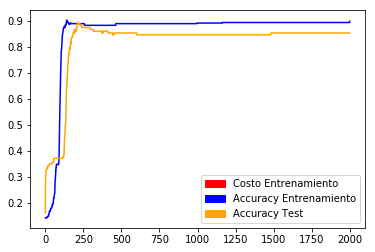

In [62]:
## Funcion para graficar el costo y  accuracy durante cada iteracion ##
helper.training_graph(cost_vect, acc_vect, acc_vect_test)

#### Accuracy con el Test set [Modelo 4]

In [63]:
y_predict = prediccion(X_test_features, modelo_4_theta_values, True)

In [64]:
print('Accuracy:',accuracy_score(y_test, y_predict)* 100 ,'%')

Accuracy: 85.3146853146853 %


#### Matriz de confusion Test Set [Modelo 4]

In [65]:
confusion_matrix(y_test, y_predict)

array([[33, 20],
       [ 1, 89]], dtype=int64)

In [66]:
print('precision: ',precision_score(y_test, y_predict))

print('recall: ', recall_score(y_test, y_predict))

precision:  0.8165137614678899
recall:  0.9888888888888889


## Entrenamiento modelo 5

#### Sampleo bootstrap

In [67]:
X_train_m5, Y_train_m5 = resample(X_train, y_train, n_samples = 460)

### Filtrar Features
Solo seleccionar los features

In [68]:
'''
Ingresa en la lista el nombre de las fatrues que quieres utlizar en este modelo (~1 linea)
'''
features_filtro = ['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness']

In [69]:
X_train_m5 = helper.fitrar_nombre(X_train_m5,data.feature_names,features_filtro)
X_test_features = helper.fitrar_nombre(X_test,data.feature_names,features_filtro)

In [70]:
## Numero de iteracions ##
iterations = 2000 # Define el numero de iteraciones #

## Alpha ##
alpha = 0.005 # Define el valor de alpha #

#### No hay que cambiar el codigo despues de esta linea #####
## Numero de feautres ##
numero_features = X_train_m5.shape[1] + 1

## Creamos un vector donde se almacenan los valores de Theta,
## lo inicializamos con numeros aleatorios
theta_vector = np.random.rand(numero_features)

## Normaliza las features de X_train_features (~1 linea) ##
X_train_m5 = normalizar(X_train_m5)

# Creando la Matriz X de features
X_train_features = np.ones((X_train_m5.shape[0], numero_features))
X_train_features[:,:-1] = X_train_m5

In [71]:
## Llama a la funcion de gradient descent, recurda definir un nombre diferente para el modelo (~1 linea) ##
modelo_5_theta_values, cost_vect, acc_vect, acc_vect_test = \
gradient_descent(X_train_features, Y_train_m5, theta_vector, alpha, iterations, X_test_features, y_test, 'modelo_5')

C:\Users\Admin VDK\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


#####################
TRAINING: [Iteracion:  0  Costo:  nan  Accuracy: 0.6173913043478261  F1 Score: 0.7634408602150538 Precision training: 0.6367713004484304 Recall training: <function recall at 0x000002040C1480D0> ]
TEST: [Iteracion:  0 Accuracy: 0.6083916083916084  F1 Score: 0.7565217391304347 Precision Test: 0.6214285714285714 Recall Test: 0.9666666666666667 ]
#####################
TRAINING: [Iteracion:  300  Costo:  nan  Accuracy: 0.4369565217391304  F1 Score: 0.6081694402420574 Precision training: 0.5537190082644629 Recall training: <function recall at 0x000002040C1480D0> ]
TEST: [Iteracion:  300 Accuracy: 0.26573426573426573  F1 Score: 0.0 Precision Test: 0.0 Recall Test: 0.0 ]


C:\Users\Admin VDK\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Admin VDK\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#####################
TRAINING: [Iteracion:  600  Costo:  nan  Accuracy: 0.8521739130434782  F1 Score: 0.8924050632911392 Precision training: 0.844311377245509 Recall training: <function recall at 0x000002040C1480D0> ]
TEST: [Iteracion:  600 Accuracy: 0.3706293706293706  F1 Score: 0.0 Precision Test: 0.0 Recall Test: 0.0 ]
#####################
TRAINING: [Iteracion:  900  Costo:  nan  Accuracy: 0.8739130434782608  F1 Score: 0.9099378881987578 Precision training: 0.846820809248555 Recall training: <function recall at 0x000002040C1480D0> ]
TEST: [Iteracion:  900 Accuracy: 0.7902097902097902  F1 Score: 0.8076923076923077 Precision Test: 0.9545454545454546 Recall Test: 0.7 ]
#####################
TRAINING: [Iteracion:  1200  Costo:  nan  Accuracy: 0.8673913043478261  F1 Score: 0.9057187017001546 Precision training: 0.839541547277937 Recall training: <function recall at 0x000002040C1480D0> ]
TEST: [Iteracion:  1200 Accuracy: 0.8671328671328671  F1 Score: 0.8950276243093923 Precision Test: 0

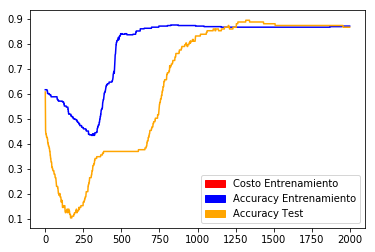

In [72]:
## Funcion para graficar el costo y  accuracy durante cada iteracion ##
helper.training_graph(cost_vect, acc_vect, acc_vect_test)

#### Accuracy con el Test set [Modelo 5]

In [73]:
y_predict = prediccion(X_test_features, modelo_4_theta_values, True)

In [74]:
print('Accuracy:',accuracy_score(y_test, y_predict)* 100 ,'%')

Accuracy: 85.3146853146853 %


#### Matriz de confusion Test Set [Modelo 5]

In [75]:
confusion_matrix(y_test, y_predict)

array([[33, 20],
       [ 1, 89]], dtype=int64)

In [76]:
print('precision: ',precision_score(y_test, y_predict))

print('recall: ', recall_score(y_test, y_predict))

precision:  0.8165137614678899
recall:  0.9888888888888889


# Comparacion de Modelos
Es importante llevar un registro de los resultados de nuestros modelos y los hyperparametros que utilizamos, para ir comparando y ajustando los modelos. En nuestra función de gradient descent esta implementado un registro a bitacora, que almacena cada ejecucion de la funcion.

Este registro almacena datos que nos van a servir para comprar los modelos y tambien almacena los valores theta del modelo, por lo que podemos guardar los modelos y utlizarlos despues.
A continuacion vamos a desplegar en la siguiente celda y nos va ayudar a tomar una decisión de cual es el mejor modelo.

Es recomendable que, luego de analizar los resultados del registro ejecutemos de nuevo alguno de los modelos cambiando los hyperparametros o numero de ejemplos y ver con cuales obtenemos mejores resultados.

Podemos ejecutar la funcion `helper.guardar_log_book(log_book)` para almacenar en disco los modelos.

Para el ultimo paso donde exportamos el modelo debemos utilizar la funcion `helper.filter_log_book(log_book, nombre_modelo)` para obtener el mejor modelo y exportalo.

In [77]:
helper.print_log_book(log_book)

,Nombre Modelo,Numero de features,Numero de ejemplos,Alpha,Numero de Iteraciones,Accuracy Training,Accuracy Test,F1 score Test,Precision Test,Recall Test
0,modelo_1_131752473363,5,150,0.010,500,0.686667,0.664336,0.789474,0.652174,1.000000
1,modelo_1_132034622799,5,150,0.010,500,0.906667,0.874126,0.906250,0.852941,0.966667
2,modelo_2_132039593654,3,400,0.050,1000,0.907500,0.874126,0.906250,0.852941,0.966667
3,modelo_5_132042169998,5,460,0.005,2000,0.882609,0.860140,0.891304,0.872340,0.911111
4,modelo_4_132042578184,5,460,0.005,2000,0.619565,0.629371,0.772532,0.629371,1.000000
5,modelo_4_132042262012,5,460,0.005,2000,0.619565,0.629371,0.772532,0.629371,1.000000
6,modelo_3_132043279118,4,460,0.020,1500,0.882609,0.860140,0.897959,0.830189,0.977778
7,modelo_4_132043291832,5,460,0.030,1000,0.886957,0.874126,0.906250,0.852941,0.966667
8,modelo_5_132043126278,5,460,0.005,2000,0.869565,0.874126,0.906250,0.852941,0.966667
9,modelo_1_132049520640,5,150,0.010,2000,0.913333,0.860140,0.896907,0.836538,0.966667


### Guardando la bitacora

In [78]:
helper.guardar_log_book(log_book)

## Exportar el modelo

Vamos a exportar el modelo para poder hacer deploy, ** el modelo exportado debe tener las cinco primeras feautures **. Por lo cual de todos tus experimentos, selecciona el mejor modelo que cumpla con usar las 5 features ya mencionadas.

Selecciona tu mejor modelo:

### Seleccionamos el mejor modelo

Para seleccionar un modelo utilizamos la funcion `helper.filter_log_book()`.

Esta funcion recibe de parametros la bitacora y el nombre del modelo que elegiste como el mejor

`helper.filter_log_book(log_book, <nombre de nuestro mejor modelo>)`

In [80]:
### INICIO: TU CODIGO AQUI:  (~1 linea)###
modelo = helper.filter_log_book(log_book, 'modelo_1_141732018933')

print(modelo)

[-0.12655108275853844, -0.47242512023140953, -0.35407275630946033, -1.107091981195825, 0.2435440101912242, 1.9584778168199795]


Se va a utilizar el siguiente codigo para guardar el modelo elegido en un archivo.

Esto genera 2 archivos, en un archivo _model.csv se tienen los parametros de el modelo elegido.

El segundo archivo llamado _momentos.csv guarda la media y desviacion estandar de cada features, esto sera utilizado
en la aplicacion hecha por el profesor para aplicar normalizacion al realizar predicciones.

No hay que cambiar nada de codigo, solo hay que ejecutar la celda para exportar nuestro modelo y luego enviar los archivos .csv al profesor

In [81]:
import csv

def exportar_modelo(model,carnet):
    norm_std, norm_media = helper.get_normalizacion_vales(X_train[:,0:5])
    with open(carnet + '_model.csv', 'w') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        filewriter.writerow(model)
        
    with open(carnet + '_momentos.csv', 'w') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        filewriter.writerow(norm_std)
        filewriter.writerow(norm_media)
        
    print('El modelo ha sido exportado [',csvfile.name,']')
    
exportar_modelo(modelo,carnet)

El modelo ha sido exportado [ 20150066_momentos.csv ]


<img src="images/ai_cancer.png" width="700">

# Una vez elegido y exportado tu modelo , debes enviar los archivos .csv resultantes al profesor por correo